In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

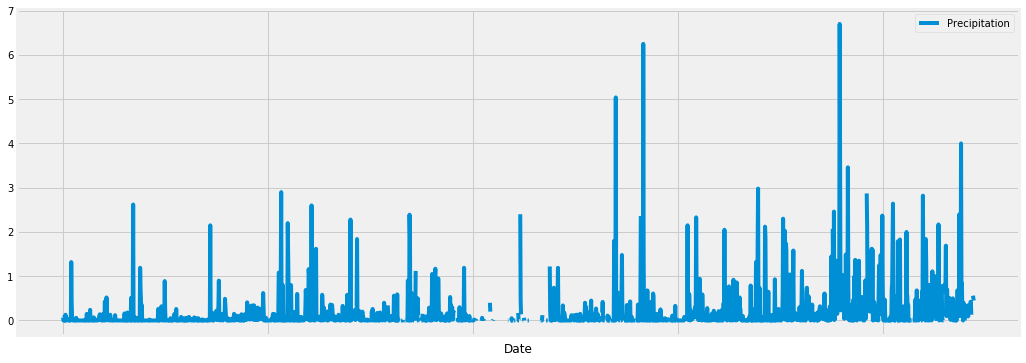

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest = session.query(func.max(Measurement.date)).scalar()

year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
threesixtyfive = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
cli_df = pd.DataFrame(threesixtyfive, columns=['Date','Precipitation'])

# Sort the dataframe by date
cli_df.sort_values("Date")

#set index for df
cli_df.set_index("Date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
cli_df.plot(figsize=(16,6), x_compat = True)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
cli_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
#inspect(engine).get_columns("Station")

station_count = session.query(Station.id).count()
print(f"There are {station_count} stations in the dataset")

There are 9 stations in the dataset


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

#for loop so that we have a prettier list
station_order = 0

for station in active_stations:
    station_order += 1
    print(f"{station_order}. Station {station[0]} had {station[1]} rows of data")

1. Station USC00519281 had 2772 rows of data
2. Station USC00519397 had 2724 rows of data
3. Station USC00513117 had 2709 rows of data
4. Station USC00519523 had 2669 rows of data
5. Station USC00516128 had 2612 rows of data
6. Station USC00514830 had 2202 rows of data
7. Station USC00511918 had 1979 rows of data
8. Station USC00517948 had 1372 rows of data
9. Station USC00518838 had 511 rows of data


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#mma stands for min max average
mma = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter_by(station = active_stations[0][0]).all()

#print things nicely
print(f"Station {active_stations[0][0]} recorded the following data:")
print(f"Lowest temperature: {mma[0][0]}")
print(f"Highest temperature: {mma[0][1]}")
print(f"Average temperature: {mma[0][2]}")

Station USC00519281 recorded the following data:
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


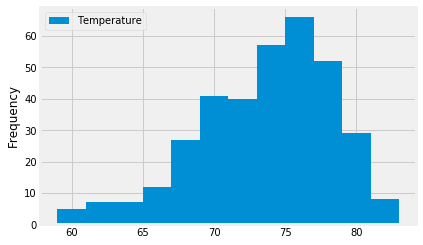

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

mas = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > year_ago).\
        filter_by(station = active_stations[0][0]).all()

mas_df = pd.DataFrame(mas, columns=["Date","Temperature"])

mas_df.plot(kind="hist", bins=12, figsize=(6,4))

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2016-08-23', '2017-08-23')

trip_df = pd.DataFrame(trip_temps, columns=["tmin", "tavg", "tmax"])

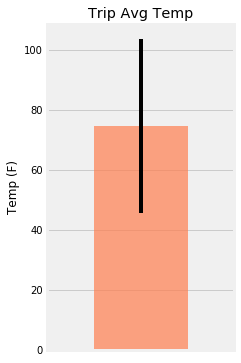

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_bar = trip_df["tavg"]

#peak to peak
ptp = trip_df["tmax"] - trip_df["tmin"]

avg_bar.plot(kind="bar", yerr=ptp, figsize = (3,6), color="coral", alpha = 0.7)

#remove text under graph
plt.xticks([])

plt.ylabel("Temp (F)")

plt.title("Trip Avg Temp")

plt.show()

In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(Measurement.station, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation).\
            join(Station, Measurement.station == Station.station).filter(Measurement.date > year_ago)\
            .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

rainfall

[('USC00516128', 147.11000000000004, 21.3331, -157.8025, 152.4),
 ('USC00519281', 68.24000000000002, 21.45167, -157.84888999999998, 32.9),
 ('USC00513117', 48.36000000000003, 21.4234, -157.8015, 14.6),
 ('USC00519523', 37.99, 21.33556, -157.71139, 19.5),
 ('USC00514830', 33.19, 21.5213, -157.8374, 7.0),
 ('USC00519397', 16.089999999999986, 21.2716, -157.8168, 3.0),
 ('USC00517948', 4.59, 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [80]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "01-01-2017"
end_date = "01-07-2017"

# Use the start and end date to create a range of dates
date_range = pd.date_range(start= start_date, end= end_date, freq= "D")

# Stip off the year and save a list of %m-%d strings
trip_dates = date_range.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date

normals=[]

for date in trip_dates:
    normals.append(daily_normals(date)[0])
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [81]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
challenge_df = pd.DataFrame(normals, columns=["tmin","tavg","tmax"])

#load trip_dates as date
challenge_df['Date']= trip_dates

#and set it as index
challenge_df.set_index("Date")

,tmin,tavg,tmax
Date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0


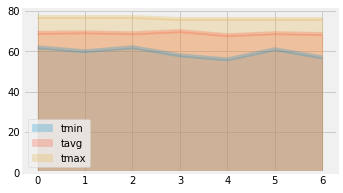

In [113]:
# Plot the daily normals as an area plot with `stacked=False`

challenge_df.plot.area(stacked=False, alpha=0.25, figsize=(5,3))